In [1]:
import firedrake as fd

In [2]:
import matplotlib.pyplot as plt
import numpy as np

[ 0.74333214  0.97949805 -1.09732563 -0.10659039]


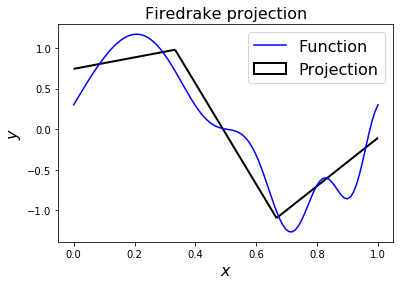

In [10]:
# use an in-built Firedrake function to generate a 1D mesh
mesh = fd.IntervalMesh(3, 1.0)
# define a function space on this mesh - here p/w linear continuous or "P1CG"
V = fd.FunctionSpace(mesh, "CG", 1)
# define the spatial coordinates from the mesh
x = fd.SpatialCoordinate(mesh)

# The function we want to project as a UFL expression
f = fd.sin(2*fd.pi*x[0]) + 0.3*fd.cos(3.*2.*fd.pi*x[0]**2)

# Define test and trial function spaces for use in the weak form definition.
# The same here as we are using a "Galerkin" discretisation
u = fd.TrialFunction(V)
v = fd.TestFunction(V)

# weak or variational form - integrated by parts
F = (u - f)*v*fd.dx  # or F = u*v*fd.dx - f*v*fd.dx
# form the LHS and RHS parts
a, L = fd.lhs(F), fd.rhs(F)

# redefine u to be a solution function
u = fd.Function(V)
# solve a u = L for u given a and L
fd.solve(a == L, u)

# print out the solution values at the nodes
print(u.vector().array())

# plot the Firedrake derived solution against the original function
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Firedrake projection', fontsize=16)
fd.plot(u, axes=ax1)

def f_fun(x):
    return np.sin(2*np.pi*x) + 0.3*np.cos(3.*2.*np.pi*x**2)

x_fine = np.linspace(0,1,100)
ax1.plot(x_fine, f_fun(x_fine), 'b-')
ax1.legend(("Function","Projection"), loc="best", fontsize=16);

## Pressure driven channel

In [ ]:
print("Setting up solver.")

# physical constants
nu = fd.Constant(1)

# time step
dt = 0.05
# define a firedrake constant equal to dt so that variation forms 
# not regenerated if we change the time step
k = fd.Constant(dt)

# mesh
Nx = 10
Ny = Nx
mesh = fd.UnitSquareMesh(Nx, Ny)

# function spaces
V = fd.VectorFunctionSpace(mesh, "CG", 2)
Q = fd.FunctionSpace(mesh, "CG", 1)

# define trial and test functions
u = fd.TrialFunction(V)
v = fd.TestFunction(V)

p = fd.TrialFunction(Q)
q = fd.TestFunction(Q)

u_now = fd.Function(V)
u_next = fd.Function(V)
u_star = fd.Function(V)
p_now = fd.Function(Q)
p_next = fd.Function(Q)

# Expressions for the variational forms
n = fd.FacetNormal(mesh)
f = fd.Constant((0.0, 0.0))
u_mid = 0.5*(u_now + u)

def sigma(u, p):
    """Stress tensor"""
    return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))

# Define boundary conditions
# pressure BCs 
bcu = fd.DirichletBC(V, fd.Constant((0.0, 0.0)), (3, 4))  # no slip on walls
bcp = [fd.DirichletBC(Q, fd.Constant(8.0), 1),  # inflow pressure of 8
       fd.DirichletBC(Q, fd.Constant(0.0), 2)]  # outflow pressure of 0

# Define variational forms 
# The Navier-Stokes momentum equation ...
# time derivative
'''
test dot instead of inner
# F1 = fd.inner((u - u_now)/k, v) * fd.dx \
'''
F1 = fd.dot((u - u_now)/k , v) * fd.dx \
# advection (fully explicit)
'''
test grad instead of nabla_grad
F1 += fd.inner(fd.dot(u_now, fd.nabla_grad(u_now)), v) * fd.dx \
'''
F1 += fd.dot(fd.dot(u_now, fd.nabla_grad(u_now)), v) * fd.dx \
# stress (Crank-Nicolson for viscosity, explicit for pressure)
F1 += fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
# pressure boundary term
F1 += fd.inner(p_now * n, v) * fd.ds \
# diffusion boundary term
F1 -= fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
# source term
F1 -= fd.inner(f, v) * fd.dx

a1, L1 = fd.system(F1)

# variational form corresponding to the pressure Poisson equation
a2 = fd.inner(fd.nabla_grad(p), fd.nabla_grad(q)) * fd.dx
L2 = fd.inner(fd.nabla_grad(p_now), fd.nabla_grad(q)) * fd.dx \
    - (1/k) * fd.inner(fd.div(u_star), q) * fd.dx

# variational form corresponding to the velocity update
a3 = fd.inner(u, v) * fd.dx
L3 = fd.inner(u_star, v) * fd.dx \
     - k * fd.inner(fd.nabla_grad(p_next - p_now), v) * fd.dx

# Define linear problems
prob1 = fd.LinearVariationalProblem(a1, L1, u_star, bcs=bcu)
prob2 = fd.LinearVariationalProblem(a2, L2, p_next, bcs=bcp)
prob3 = fd.LinearVariationalProblem(a3, L3, u_next)

# Define solvers. ksp_type is a Petsc keyword to define the solver, pc_type the preconditioner
solve1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'gmres', 'pc_type': 'sor'}) 
solve2 = fd.LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'cg', 'pc_type': 'gamg'}) 
solve3 = fd.LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'}) 

'''
# Prep for saving solutions
u_save = fd.Function(V).assign(u_now)
p_save = fd.Function(Q).assign(p_now)
outfile_u = fd.File("outputs/2D/channel/u.pvd")
outfile_p = fd.File("outputs/2D/channel/p.pvd")
outfile_u.write(u_save)
outfile_p.write(p_save)
'''

# Time loop
t = 0.0
t_end = 10.0

print("Beginning time loop...")

#for steps in range(num_steps):
while t < t_end:
    solve1.solve()
    solve2.solve()
    solve3.solve()

    t += dt

    '''
    u_save.assign(u_next)
    p_save.assign(p_next)
    outfile_u.write(u_save)
    outfile_p.write(p_save)
    '''

    # update solutions
    u_now.assign(u_next)
    p_now.assign(p_next)
    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")

In [ ]:
fig = plt.figure(figsize=(6, 5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(u_now,axes=ax1)

In [ ]:
# compute and plot an error based on exact solution being a quadratic
N = 100
locs = np.zeros((N,2))
locs[:,0] = 0.5*np.ones(N)
locs[:,1] = np.linspace(0.01,0.99,N)

ux_locs = u_now.at(locs)
ux = [ux_loc[0] for ux_loc in ux_locs]

y = locs[:,1]
ux_exact = 4*y*(1-y)
error = np.linalg.norm(ux - ux_exact) / np.sqrt(len(ux))
print('RMS error = ',error)
fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$u_h - u_{exact}$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - error', fontsize=16)
ax1.plot(ux - ux_exact, 'b-');

In [16]:
fd.nabla_grad?

In [ ]:
fd.grad?

In [ ]:
fd.inner?

In [ ]:
fd.dot?

In [ ]:
fd.system?

In [ ]:
fd.FacetNormal?

In [ ]:
fd.VectorFunctionSpace?

In [ ]:
fd.LinearVariationalProblem?

## Flow in Cylinder

In [3]:
print("Setting up solver.")

# physical constants
nu = fd.Constant(0.001)

# time step
dt = 0.001
# define a firedrake constant equal to dt so that variation forms 
# not regenerated if we change the time step
k = fd.Constant(dt)

mesh = fd.Mesh("flow_past_cylinder.msh")

V = fd.VectorFunctionSpace(mesh, "CG", 2)
Q = fd.FunctionSpace(mesh, "CG", 1)

u = fd.TrialFunction(V)
v = fd.TestFunction(V)

p = fd.TrialFunction(Q)
q = fd.TestFunction(Q)

u_now = fd.Function(V)
u_next = fd.Function(V)
u_star = fd.Function(V)
p_now = fd.Function(Q)
p_next = fd.Function(Q)

# Expressions for the variational forms
n = fd.FacetNormal(mesh)
f = fd.Constant((0.0, 0.0))
u_mid = 0.5*(u_now + u)

def sigma(u, p):
    return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))


x, y = fd.SpatialCoordinate(mesh)

# Define boundary conditions
bcu = [fd.DirichletBC(V, fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
          fd.DirichletBC(V, ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
bcp = [fd.DirichletBC(Q, fd.Constant(0), 3)]  # outflow

# Define variational forms
F1 = fd.inner((u - u_now)/k, v) * fd.dx \
    + fd.inner(fd.dot(u_now, fd.nabla_grad(u_mid)), v) * fd.dx \
    + fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
    + fd.inner(p_now * n, v) * fd.ds \
    - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
    - fd.inner(f, v) * fd.dx

a1, L1 = fd.system(F1)

a2 = fd.inner(fd.nabla_grad(p), fd.nabla_grad(q)) * fd.dx
L2 = fd.inner(fd.nabla_grad(p_now), fd.nabla_grad(q)) * fd.dx \
    - (1/k) * fd.inner(fd.div(u_star), q) * fd.dx

a3 = fd.inner(u, v) * fd.dx
L3 = fd.inner(u_star, v) * fd.dx \
     - k * fd.inner(fd.nabla_grad(p_next - p_now), v) * fd.dx

# Define linear problems
prob1 = fd.LinearVariationalProblem(a1, L1, u_star, bcs=bcu)
prob2 = fd.LinearVariationalProblem(a2, L2, p_next, bcs=bcp)
prob3 = fd.LinearVariationalProblem(a3, L3, u_next)

# Define solvers
solve1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'gmres', 'pc_type': 'sor'})  
solve2 = fd.LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'cg', 'pc_type': 'gamg'})  
solve3 = fd.LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'})  

# Prep for saving solutions
u_save = fd.Function(V).assign(u_now)
p_save = fd.Function(Q).assign(p_now)
outfile_u = fd.File("outputs/2D/cylinder/u.pvd")
outfile_p = fd.File("outputs/2D/cylinder/p.pvd")
outfile_u.write(u_save)
outfile_p.write(p_save)

# Time loop
t = 0.0
t_end = 5.

print("Beginning time loop...")

while t < t_end :
    solve1.solve()
    solve2.solve()
    solve3.solve()

    t += dt

    u_save.assign(u_next)
    p_save.assign(p_next)
    outfile_u.write(u_save)
    outfile_p.write(p_save)

    # update solutions
    u_now.assign(u_next)
    p_now.assign(p_next)

    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")

Setting up solver.
Beginning time loop...
time = 1.000
time = 2.000
time = 3.000
time = 4.000
time = 5.000
Simulation complete


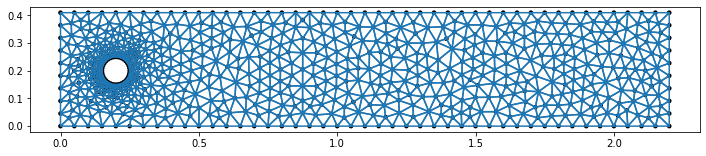

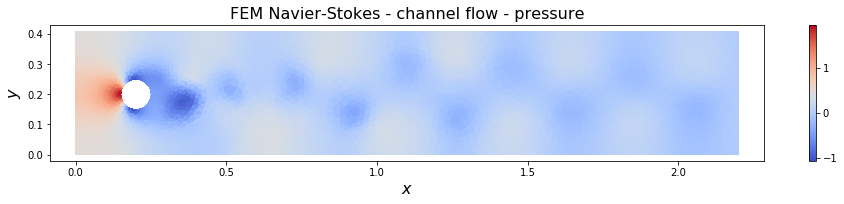

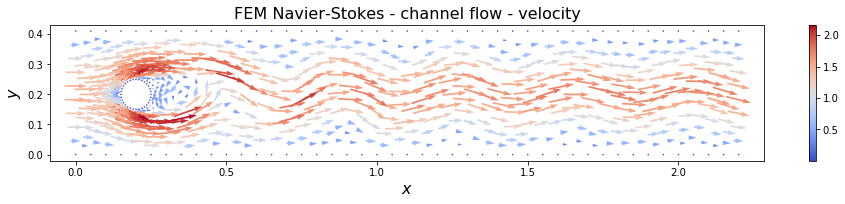

In [4]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
fd.plot(mesh, axes=ax1)

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(p_now,axes=ax1)
ax1.axis('equal')

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(u_now,axes=ax1)
ax1.axis('equal');

In [8]:
print("Setting up solver.")

# diffusion rate coeff
eps = fd.Constant(0.01)
# reaction rate coeff
K = fd.Constant(10)

v_1 = fd.TestFunction(Q)
v_2 = fd.TestFunction(Q)
v_3 = fd.TestFunction(Q)

# c = fd.Function(H)
# c_n = fd.Function(H)

# c_1, c_2 = fd.split(c)
# c_n1, c_n2 = fd.split(c_n)
c_1 = fd.Function(Q)
c_2 = fd.Function(Q)
c_3 = fd.Function(Q)
c_n1 = fd.Function(Q)
c_n2 = fd.Function(Q)
c_n3 = fd.Function(Q)


x, y = fd.SpatialCoordinate(mesh)

f_1 = fd.conditional((pow(x-0.1, 2)+pow(y-0.1,2)) < 0.0025, fd.Constant(0.1), fd.Constant(0))
f_2 = fd.conditional((pow(x-0.1, 2)+pow(y-0.3,2)) < 0.0025, fd.Constant(0.1), fd.Constant(0))
# f_2 = fd.Constant(0)
f_3 = fd.Constant(0)


# Stepwise Reactants implementation
F4 = ((c_1 - c_n1) / k)*v_1*fd.dx + fd.inner(u_now, fd.nabla_grad(c_1))*v_1*fd.dx \
      + eps*fd.inner(fd.nabla_grad(c_1), fd.nabla_grad(v_1))*fd.dx + K*fd.dot(c_1, c_n2)*v_1*fd.dx  \
      - f_1*v_1*fd.dx

F5 = ((c_2 - c_n2) / k)*v_2*fd.dx + fd.inner(u_now, fd.nabla_grad(c_2))*v_2*fd.dx \
     + eps*fd.inner(fd.nabla_grad(c_2), fd.nabla_grad(v_2))*fd.dx + K*fd.dot(c_n1, c_2)*v_2*fd.dx  \
     - f_2*v_2*fd.dx

F6 = ((c_3 - c_n3) / k)*v_3*fd.dx + fd.inner(u_now, fd.nabla_grad(c_3))*v_3*fd.dx \
     + eps*fd.inner(fd.nabla_grad(c_3), fd.nabla_grad(v_3))*fd.dx \
     + K*c_3*v_3*fd.dx - f_3*v_3*fd.dx \
     - K*fd.inner(c_n1, c_n2)*v_3*fd.dx 
     

# Define linear problems
prob4 = fd.NonlinearVariationalProblem(F4, c_1)
prob5 = fd.NonlinearVariationalProblem(F5, c_2)
prob6 = fd.NonlinearVariationalProblem(F6, c_3)

                                                     

# Define solvers
solve4 = fd.NonlinearVariationalSolver(prob4)
solve5 = fd.NonlinearVariationalSolver(prob5)
solve6 = fd.NonlinearVariationalSolver(prob6)
                                                     
# Time loop
t = 0.0
t_end = 5

print("Beginning time loop...")

while t < t_end :
                                                     
    t += dt

    solve4.solve()
    solve5.solve()
    solve6.solve()
    
    c_n1.assign(c_1)
    c_n2.assign(c_2)
    c_n3.assign(c_3)
#         c_n3.assign(c_3)
    # reset counter
                                                     
    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")


Setting up solver.
Beginning time loop...
time = 1.000
time = 2.000
time = 3.000
time = 4.000
time = 5.000
Simulation complete


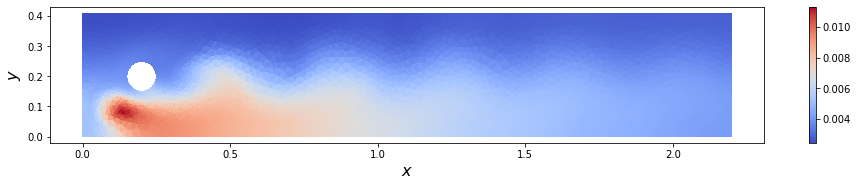

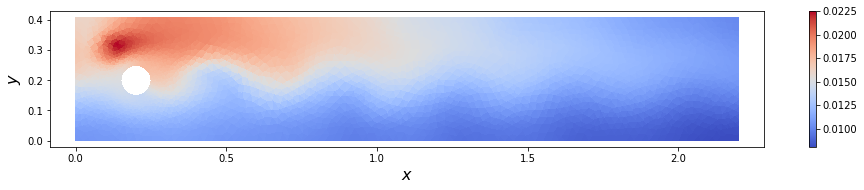

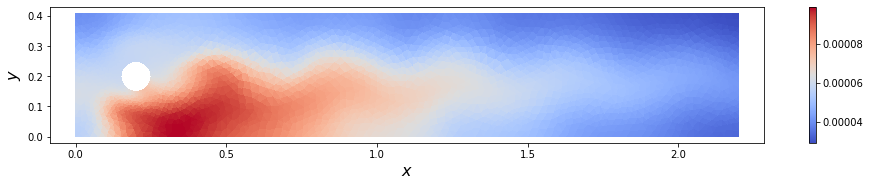

In [9]:
fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(c_1, axes=ax2)

fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(c_2, axes=ax2)
ax2.axis('equal');

fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(c_3, axes=ax2, contour=False)
ax2.axis('equal');

### Reaction from Flow in a Cylinder

In [ ]:
fd.MixedElement?

In [ ]:
fd.plot?

In [ ]:
fd.Expression?

In [ ]:
fd.DirichletBC?

### Setup Conditional

In [ ]:
print("Setting up solver.")

# physical constants
nu = fd.Constant(0.001)

# time step
dt = 0.001
# define a firedrake constant equal to dt so that variation forms 
# not regenerated if we change the time step
k = fd.Constant(dt)

''' 
new constants for reaction
'''

eps = 0.01 # diffusion rate coefficient
K = 10.0   # reaction rate

eps = fd.Constant(eps)
K = fd.Constant(K)

mesh = fd.Mesh("flow_past_cylinder.msh")

V = fd.VectorFunctionSpace(mesh, "CG", 2)
Q = fd.FunctionSpace(mesh, "CG", 1)

u = fd.TrialFunction(V)
v = fd.TestFunction(V)

p = fd.TrialFunction(Q)
q = fd.TestFunction(Q)

u_now = fd.Function(V)
u_next = fd.Function(V)
u_star = fd.Function(V)
p_now = fd.Function(Q)
p_next = fd.Function(Q)

# creating coupled variables and equations from the reaction formulas
P1 = fd.FiniteElement("CG", 'triangle', 1)
element = fd.MixedElement([P1, P1, P1])
H = fd.FunctionSpace(mesh, element)

v_1, v_2, v_3 = fd.TestFunctions(H)
c = fd.Function(H)
c_n = fd.Function(H)

c_1, c_2, c_3 = fd.split(c)
c_n1, c_n2, c_n3 = fd.split(c_n)


# Expressions for the variational forms
n = fd.FacetNormal(mesh)
f = fd.Constant((0.0, 0.0))
u_mid = 0.5*(u_now + u)

def sigma(u, p):
    return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))


x, y = fd.SpatialCoordinate(mesh)

f_1 = fd.conditional(pow(x-0.1, 2)+pow(y-0.1,2)<0.05*0.05, 0.1, 0)
f_2 = fd.conditional(pow(x-0.1, 2)+pow(y-0.3,2)<0.05*0.05, 0.1, 0)
f_3 = fd.Constant(0.0)

# Define boundary conditions
bcu = [fd.DirichletBC(V, fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
          fd.DirichletBC(V, ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
bcp = [fd.DirichletBC(Q, fd.Constant(0), 3)]  # outflow

# Define variational forms
F1 = fd.inner((u - u_now)/k, v) * fd.dx \
    + fd.inner(fd.dot(u_now, fd.nabla_grad(u_now)), v) * fd.dx \
    + fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
    + fd.inner(p_now * n, v) * fd.ds \
    - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
    - fd.inner(f, v) * fd.dx

a1, L1 = fd.system(F1)

a2 = fd.inner(fd.nabla_grad(p), fd.nabla_grad(q)) * fd.dx
L2 = fd.inner(fd.nabla_grad(p_now), fd.nabla_grad(q)) * fd.dx \
    - (1/k) * fd.inner(fd.div(u_star), q) * fd.dx

a3 = fd.inner(u, v) * fd.dx
L3 = fd.inner(u_star, v) * fd.dx \
     - k * fd.inner(fd.nabla_grad(p_next - p_now), v) * fd.dx

# Define reaction variational forms
# F4 = fd.inner((c_1 - c_n1)/k, v_1)*fd.dx + fd.inner(fd.dot(u_star, fd.nabla_grad(c_1)), v_1)*fd.dx \
#      + eps*fd.dot(fd.nabla_grad(c_1), fd.nabla_grad(v_1))*fd.dx + K*fd.inner(fd.dot(c_1, c_2), v_1)*fd.dx  \
#      - f_1*v_1*fd.dx \
#      + fd.inner((c_2 - c_n2)/k, v_2)*fd.dx + fd.inner(fd.dot(u_star, fd.nabla_grad(c_2)), v_2)*fd.dx \
#      + eps*fd.dot(fd.nabla_grad(c_2), fd.nabla_grad(v_2))*fd.dx + K*fd.inner(fd.dot(c_1, c_2), v_2)*fd.dx  \
#      - f_2*v_2*fd.dx \
#      + fd.inner((c_3 - c_n3)/k, v_3)*fd.dx + fd.inner(fd.dot(u_star, fd.nabla_grad(c_3)), v_3)*fd.dx \
#      + eps*fd.dot(fd.nabla_grad(c_3), fd.nabla_grad(v_3))*fd.dx - K*fd.inner(fd.dot(c_1, c_2), v_3)*fd.dx + K*fd.inner(c_3, v_3)*fd.dx \
#      - f_3*v_3*fd.dx

# F4 = ((c_1 - c_n1) / k)*v_1*fd.dx + fd.dot(u_next, fd.grad(c_1))*v_1*fd.dx \
#      + fd.div(eps*fd.nabla_grad(c_1))*v_1*fd.dx + K*c_1*c_2*v_1*fd.dx  \
#      + ((c_2 - c_n2) / k)*v_2*fd.dx + fd.dot(u_next, fd.grad(c_2))*v_2*fd.dx \
#      + fd.div(eps*fd.nabla_grad(c_2))*v_2*fd.dx + K*c_1*c_2*v_2*fd.dx  \
#      + ((c_3 - c_n3) / k)*v_3*fd.dx + fd.dot(u_next, fd.grad(c_3))*v_3*fd.dx \
#      + fd.div(eps*fd.nabla_grad(c_3))*v_3*fd.dx - K*c_1*c_2*v_3*fd.dx + K*c_3*v_3*fd.dx \
#      - f_1*v_1*fd.dx - f_2*v_2*fd.dx - f_3*v_3*fd.dx
                                                    
# Copied from the FENICS implementation
F4 = ((c_1 - c_n1) / k)*v_1*fd.dx + fd.dot(u_next, fd.nabla_grad(c_1))*v_1*fd.dx \
     + eps*fd.dot(fd.grad(c_1), fd.grad(v_1))*fd.dx + K*c_1*c_2*v_1*fd.dx  \
     + ((c_2 - c_n2) / k)*v_2*fd.dx + fd.dot(u_next, fd.nabla_grad(c_2))*v_2*fd.dx \
     + eps*fd.dot(fd.grad(c_2), fd.grad(v_2))*fd.dx + K*c_1*c_2*v_2*fd.dx  \
     + ((c_3 - c_n3) / k)*v_3*fd.dx + fd.dot(u_next, fd.nabla_grad(c_3))*v_3*fd.dx \
     + eps*fd.dot(fd.grad(c_3), fd.grad(v_3))*fd.dx - K*c_1*c_2*v_3*fd.dx + K*c_3*v_3*fd.dx \
     - f_1*v_1*fd.dx - f_2*v_2*fd.dx - f_3*v_3*fd.dx

#a4, L4 = fd.system(F4)

# Define linear problems
prob1 = fd.LinearVariationalProblem(a1, L1, u_star, bcs=bcu)
prob2 = fd.LinearVariationalProblem(a2, L2, p_next, bcs=bcp)
prob3 = fd.LinearVariationalProblem(a3, L3, u_next)
prob4 = fd.NonlinearVariationalProblem(F4, c)

                                                     

# Define solvers
solve1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'gmres', 'pc_type': 'sor'})  
solve2 = fd.LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'cg', 'pc_type': 'gamg'})  
solve3 = fd.LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'})
solve4 = fd.NonlinearVariationalSolver(prob4)  



# # Prep for saving solutions
# u_save = fd.Function(V).assign(u_now)
# p_save = fd.Function(Q).assign(p_now)
# outfile_u = fd.File("outputs/2D/cylinder/u.pvd")
# outfile_p = fd.File("outputs/2D/cylinder/p.pvd")
# outfile_u.write(u_save)
# outfile_p.write(p_save)
                                                     
# Time loop
t = 0.0
t_end = 5.

print("Beginning time loop...")

while t < t_end :
                                                     
    t += dt
    
    solve1.solve()
    solve2.solve()
    solve3.solve()
    solve4.solve()
#           # Use Newton-Krylov iterations to solve the nonlinear
#           # system, using direct factorisation to solve the linear system.
#           solver_parameters={"snes_type": "newtonls",
#                              "ksp_type" : "preonly",
#                              "pc_type" : "lu"})
    #solve4.solve()

#     u_save.assign(u_next)
#     p_save.assign(p_next)
#     outfile_u.write(u_save)
#     outfile_p.write(p_save)

    # update solutions
    u_now.assign(u_next)
    p_now.assign(p_next)
    _c_1, _c_2, _c_3 = c.split()
    c_n.assign(c)
                                                     
    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")


In [ ]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
fd.plot(mesh, axes=ax1)

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - pressure', fontsize=16)
fd.plot(p_now,axes=ax1)
ax1.axis('equal')

fig = plt.figure(figsize=(16, 2.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('FEM Navier-Stokes - channel flow - velocity', fontsize=16)
fd.plot(u_now,axes=ax1)
ax1.axis('equal');

In [ ]:
_c_1, _c_2, _c_3 = c_n.split()

In [ ]:
fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(_c_1, axes=ax2)

fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(_c_2, axes=ax2)
ax2.axis('equal');

fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(_c_3, axes=ax2, contour=False)
ax2.axis('equal');

In [ ]:
fd.conditional?

In [ ]:
fd.And?

In [ ]:
fd.plot?

In [15]:
fd.grad?

In [ ]:
infile = File()

In [ ]:
fd.File?

In [ ]:
fd.solve?

In [ ]:
fd.split?

In [ ]:
fd.Function?

In [ ]:
fd.NonlinearVariationalProblem?

In [ ]:
fd.LinearVariationalProblem?

In [ ]:
fd.NonlinearVariationalSolver?

In [ ]:
c_n.assign?

In [ ]:
.assign

In [ ]:
fd.dx?

In [ ]:
.vector.retrieve

## Separated Reactants and Products Approach

In [ ]:
print("Setting up solver.")

# physical constants
nu = fd.Constant(0.001)
# time step
dt = 0.001
k = fd.Constant(dt)
dt2 = 0.01
k2 = fd.Constant(dt2)
# diffusion rate coeff
eps = fd.Constant(0.01)
# reaction rate coeff
K = fd.Constant(10)


mesh = fd.Mesh("flow_past_cylinder.msh")

V = fd.VectorFunctionSpace(mesh, "CG", 2)
Q = fd.FunctionSpace(mesh, "CG", 1)

u = fd.TrialFunction(V)
v = fd.TestFunction(V)

p = fd.TrialFunction(Q)
q = fd.TestFunction(Q)

u_now = fd.Function(V)
u_next = fd.Function(V)
u_star = fd.Function(V)
p_now = fd.Function(Q)
p_next = fd.Function(Q)

# creating coupled variables and equations from the reaction formulas
P1 = fd.FiniteElement("CG", 'triangle', 1)
element = fd.MixedElement([P1, P1])
H = fd.FunctionSpace(mesh, element)

v_1 = fd.TestFunction(Q)
v_2 = fd.TestFunction(Q)
v_3 = fd.TestFunction(Q)

# c = fd.Function(H)
# c_n = fd.Function(H)

# c_1, c_2 = fd.split(c)
# c_n1, c_n2 = fd.split(c_n)
c_1 = fd.Function(Q)
c_2 = fd.Function(Q)
c_3 = fd.Function(Q)
c_n1 = fd.Function(Q)
c_n2 = fd.Function(Q)
c_n3 = fd.Function(Q)

# Expressions for the variational forms
n = fd.FacetNormal(mesh)
f = fd.Constant((0.0, 0.0))
u_mid = 0.5*(u_now + u)

def sigma(u, p):
    return 2*nu*fd.sym(fd.nabla_grad(u)) - p*fd.Identity(len(u))

x, y = fd.SpatialCoordinate(mesh)

f_1 = fd.conditional((pow(x-0.1, 2)+pow(y-0.1,2)) < 0.0025, fd.Constant(0.1), fd.Constant(0))
f_2 = fd.conditional((pow(x-0.1, 2)+pow(y-0.3,2)) < 0.0025, fd.Constant(0.1), fd.Constant(0))
# f_2 = fd.Constant(0)
f_3 = fd.Constant(0)

# Define boundary conditions
bcu = [fd.DirichletBC(V, fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
          fd.DirichletBC(V, ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
bcp = [fd.DirichletBC(Q, fd.Constant(0), 3)]  # outflow

# Define variational forms
F1 = fd.inner((u - u_now)/k, v) * fd.dx \
    + fd.inner(fd.dot(u_now, fd.nabla_grad(u_now)), v) * fd.dx \
    + fd.inner(sigma(u_mid, p_now), fd.sym(fd.nabla_grad(v))) * fd.dx \
    + fd.inner(p_now * n, v) * fd.ds \
    - fd.inner(nu * fd.dot(fd.nabla_grad(u_mid), n), v) * fd.ds \
    - fd.inner(f, v) * fd.dx

a1, L1 = fd.system(F1)

a2 = fd.inner(fd.nabla_grad(p), fd.nabla_grad(q)) * fd.dx
L2 = fd.inner(fd.nabla_grad(p_now), fd.nabla_grad(q)) * fd.dx \
    - (1/k) * fd.inner(fd.div(u_star), q) * fd.dx

a3 = fd.inner(u, v) * fd.dx
L3 = fd.inner(u_star, v) * fd.dx \
     - k * fd.inner(fd.nabla_grad(p_next - p_now), v) * fd.dx
                                                    
'''# Copied from the FENICS implementation
# Only include reactants equations
# F4 =   ((c_1 - c_n1) / k)*v_1*fd.dx + fd.inner(u_now, fd.nabla_grad(c_1))*v_1*fd.dx \
#      + eps*fd.inner(fd.nabla_grad(c_1), fd.nabla_grad(v_1))*fd.dx + K*fd.inner(c_1, c_2)*v_1*fd.dx  \

#      + ((c_2 - c_n2) / k)*v_2*fd.dx + fd.inner(u_now, fd.nabla_grad(c_2))*v_2*fd.dx \
#      + eps*fd.inner(fd.nabla_grad(c_2), fd.nabla_grad(v_2))*fd.dx + K*fd.inner(c_1, c_2)*v_2*fd.dx  \
#      - f_1*v_1*fd.dx - f_2*v_2*fd.dx

# # Product equations
# F5 = ((c_3 - c_n3) / k2)*v_3*fd.dx + fd.inner(u_now, fd.nabla_grad(c_3))*v_3*fd.dx \
#      + eps*fd.inner(fd.nabla_grad(c_3), fd.nabla_grad(v_3))*fd.dx - K*fd.inner(c_1, c_2)*v_3*fd.dx + K*c_3*v_3*fd.dx \
#      - f_3*v_3*fd.dx'''

# Stepwise Reactants implementation
F4 = ((c_1 - c_n1) / k)*v_1*fd.dx + fd.inner(u_now, fd.nabla_grad(c_1))*v_1*fd.dx \
      + eps*fd.inner(fd.nabla_grad(c_1), fd.nabla_grad(v_1))*fd.dx + K*fd.dot(c_1, c_n2)*v_1*fd.dx  \
      - f_1*v_1*fd.dx

F5 = ((c_2 - c_n2) / k)*v_2*fd.dx + fd.inner(u_now, fd.nabla_grad(c_2))*v_2*fd.dx \
     + eps*fd.inner(fd.nabla_grad(c_2), fd.nabla_grad(v_2))*fd.dx + K*fd.dot(c_n1, c_2)*v_2*fd.dx  \
     - f_2*v_2*fd.dx

F6 = ((c_3 - c_n3) / k)*v_3*fd.dx + fd.inner(u_now, fd.nabla_grad(c_3))*v_3*fd.dx \
     + eps*fd.inner(fd.nabla_grad(c_3), fd.nabla_grad(v_3))*fd.dx \
     + K*c_3*v_3*fd.dx - f_3*v_3*fd.dx \
#      - K*fd.inner(c_n1, c_n2)*v_3*fd.dx 
     

# Define linear problems
prob1 = fd.LinearVariationalProblem(a1, L1, u_star, bcs=bcu)
prob2 = fd.LinearVariationalProblem(a2, L2, p_next, bcs=bcp)
prob3 = fd.LinearVariationalProblem(a3, L3, u_next)
prob4 = fd.NonlinearVariationalProblem(F4, c_1)
prob5 = fd.NonlinearVariationalProblem(F5, c_2)
prob6 = fd.NonlinearVariationalProblem(F6, c_3)

                                                     

# Define solvers
solve1 = fd.LinearVariationalSolver(prob1, solver_parameters={'ksp_type': 'gmres', 'pc_type': 'sor'})  
solve2 = fd.LinearVariationalSolver(prob2, solver_parameters={'ksp_type': 'cg', 'pc_type': 'gamg'})  
solve3 = fd.LinearVariationalSolver(prob3, solver_parameters={'ksp_type': 'cg', 'pc_type': 'sor'})
solve4 = fd.NonlinearVariationalSolver(prob4)
solve5 = fd.NonlinearVariationalSolver(prob5)
solve6 = fd.NonlinearVariationalSolver(prob6)
                                                     
# Time loop
t = 0.0
t_end = 1.2

print("Beginning time loop...")

while t < t_end :
                                                     
    t += dt

    # solve u_star
    solve1.solve()
    # solve p_next
    solve2.solve()
    # solve u_next
    solve3.solve()
    solve4.solve()
    solve5.solve()
    solve6.solve()
    
    # update solutions
    p_now.assign(p_next)
    u_now.assign(u_next)
    
    # solve c (for reactants)
    
    # solve c_3 (for products)
#         fd.solve(F5 == 0, c_3)
#     _c_1, _c_2 = c.split()
#     c_1, c_2 = fd.split(c)
#     c_n.assign(c)
#     c_n1, c_n2 = fd.split(c_n)
    c_n1.assign(c_1)
    c_n2.assign(c_2)
    c_n3.assign(c_3)
#         c_n3.assign(c_3)
    # reset counter
                                                     
    if( np.abs( t - np.round(t,decimals=0) ) < 1.e-8): 
        print('time = {0:.3f}'.format(t))

print("Simulation complete")


In [ ]:
fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(c_1, axes=ax2)

fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(c_2, axes=ax2)
ax2.axis('equal');

fig = plt.figure(figsize=(16, 2.5))
ax2 = fig.add_subplot(111)
ax2.set_xlabel('$x$', fontsize=16)
ax2.set_ylabel('$y$', fontsize=16)
fd.plot(c_3, axes=ax2, contour=False)
ax2.axis('equal');

In [ ]:
fd.Constant?

In [ ]:
fd.LinearVariationalProblem?

In [ ]:
fd.assemble?

In [13]:
fd.dot?

In [14]:
fd.inner?